# Финальный проект курса работа с данными на Python

Цель моего проекта состоит в применении на практике знаний, полученных на курсе. В рамках этого проекта я буду применять парсинг данных, а также строить графовые связи и визуализировать их.

Данные буду брать из соцсети VK, в частности, я собираюсь выявлять, кто и кому ставит лайки под фотографиями и на основании этих данных строить связи.


## Импорт библиотек

In [2]:
!pip install selenium

In [3]:
!pip install webdriver_manager

In [165]:
import pandas as pd
import time

import matplotlib.pyplot as plt

import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver import ActionChains

import networkx as nx

Я буду использовать браузер Firefox для парсинга данных, в следующей ячейке я выбираю соответствующий драйвер

In [2]:
from webdriver_manager.firefox import GeckoDriverManager

## Парсинг данных с сайта

Устанавливаю драйвер и помещаю его в соответствующую переменную

In [134]:
driver = webdriver.Firefox(executable_path = GeckoDriverManager().install())



====== WebDriver manager ======
Current firefox version is 77.0.1
Get LATEST driver version for 77.0.1
Driver [/home/alexander/.wdm/drivers/geckodriver/linux64/v0.29.1/geckodriver] found in cache


Захожу на свою страницу пользователя в ВК

In [135]:
driver.get("https://vk.com/id16793582")

Можно для наглядности ввести адрес собственной страницы

In [ ]:
driver.get(input('Введите адрес своей страницы ВК'))

В этой следующей ячейке я попытался зарегистрировать свою программу как отдельного пользователя, но система верификации с помощью телефона меня победила =)

#Ввод имени и фамилии
first_name = 'firefox'
last_name = 'browser'

driver.find_element_by_id('ij_last_name').send_keys(last_name)
time.sleep(1)
driver.find_element_by_id('ij_first_name').send_keys(first_name)
time.sleep(1)

#Заполнение даты рождения
driver.find_element_by_id('container1').click()
time.sleep(1)
driver.find_element_by_id('option_list_options_container_1_5').click()
time.sleep(1)
driver.find_element_by_id('container2').click()
time.sleep(1)
driver.find_element_by_id('option_list_options_container_2_5').click()
time.sleep(1)
driver.find_element_by_id('container3').click()
time.sleep(1)
driver.find_element_by_id('option_list_options_container_3_5').click()
time.sleep(1)

#Выбор пола
driver.find_element_by_xpath('/html/body/div[10]/div/div/div[2]/div[2]/div[2]/div/div/div/div[1]/div[2]/div[2]/div[5]/div[2]').click()
time.sleep(1)

#Завершение регистрации и переход к верификации
driver.find_element_by_id('ij_submit').click()
time.sleep(5)

#Для верификации требуется номер телефона. Случайный номер не подошёл.
driver.find_element_by_id('container1').click()
time.sleep(1)
driver.find_element_by_id('option_list_options_container_1_9').click()
time.sleep(1)
driver.find_element_by_id('join_phone').send_keys('2025550157')
time.sleep(1)
driver.find_element_by_id('join_send_phone').click()

Поэтому я просто использую данные своей учётной записи

In [136]:
driver.find_element_by_id('quick_email').send_keys(input('Введите логин ВК '))
time.sleep(1)
driver.find_element_by_id('quick_pass').send_keys(input('Введите пароль ВК '))
time.sleep(1)
driver.find_element_by_id('quick_login_button').click()
time.sleep(5)

Введите логин ВКВведите пароль ВК

Далее я создаю несколько функций для их дальнейшего многократного использования:

show_avatar_likes открывает фотографию-аватар на странице пользователя и далее открывает список людей, поставивших лайк этой фотографии.

scroll_layer_down нужен для отображения всех лайков. В изначально открывшемся списке их только 60. При прокрутке списка вниз загружаются новые данные.

gather_likes_info создаёт списки с именами пользователей и ссылками на их страницу.

add_likes_to_dataset использует предыдущую функцию для сбора информации, создаёт дополнительные списки для заполнения других столбцов датасета и добавляет всю эту информацию в датасет.

In [106]:
def show_avatar_likes():
    driver.find_element_by_id('page_avatar_wrap').click()
    time.sleep(1)
    like_button = driver.find_element_by_class_name('like_btn.like._like')
    ActionChains(driver).move_to_element(like_button).pause(2).perform()
    like_header = driver.find_element_by_class_name('like_tt_header')
    ActionChains(driver).move_to_element(like_header).click().perform()

In [107]:
def scroll_layer_down():
    driver.find_element_by_id('wk_layer_wrap').send_keys(Keys.END)


In [130]:
def gather_likes_info():
    time.sleep(2)
    for i in range(50):
        scroll_layer_down()
        time.sleep(0.02)
    fan_list = driver.find_elements_by_class_name('fans_fan_name')
    fan_link_list = driver.find_elements_by_class_name('fans_fan_lnk')
    names = []
    link1 = []
    for fan in fan_list:
        names.append(fan.text)
    for link in fan_link_list:
        link1.append(link.get_attribute('href'))
    return names, link1

In [109]:
def add_likes_to_dataset(VK_likes_dataset):
    fans, links = gather_likes_info()
    Whom = [driver.find_element_by_class_name('author').get_attribute('text')] * len(fans)
    link2 = [driver.find_element_by_class_name('author').get_attribute('href')] * len(fans)
    for fan, link_1, author, link_2 in zip(fans, links, Whom, link2):
        VK_likes_dataset = VK_likes_dataset.append({"кто_поставил": fan, 
                                                    "vk_id": link_1, 
                                                    "кому_поставили": author, 
                                                    "vk_id_2": link_2},
                                                   ignore_index = True)
    return VK_likes_dataset

В следующей ячейке я инициализирую пока ещё пустой датасет. 

В нём 4 столбца:
* кто_поставил (кто поставил лайк, имя пользователя)
* vk_id (ссылка на пользователя, который поставил лайк)
* кому_поставили (кому поставили лайк, имя пользователя)
* vk_id_2 (ссылка на пользователя, которому поставили лайк)

In [137]:
VK_likes_dataset = pd.DataFrame(columns = ['кто_поставил', 'vk_id', 'кому_поставили', 'vk_id_2'])
VK_likes_dataset

,кто_поставил,vk_id,кому_поставили,vk_id_2


Теперь я тестово запускаю процесс сбора лайков на своей странице. Для начала вызову функцию show_avatar_likes.

In [138]:
show_avatar_likes()

Дальше мне нужно вызвать функцию add_likes_to_dataset и она соберёт всю информацию в мой датасет.

In [139]:
VK_likes_dataset = add_likes_to_dataset(VK_likes_dataset)

In [140]:
VK_likes_dataset

,кто_поставил,vk_id,кому_поставили,vk_id_2
0,Никита Образцов,https://vk.com/id57709373,Саша Ким,https://vk.com/id16793582
1,Николай Придачин,https://vk.com/id25089,Саша Ким,https://vk.com/id16793582
2,Дарья Хмельницкая,https://vk.com/id77888,Саша Ким,https://vk.com/id16793582
3,Татьяна Ли,https://vk.com/mitchinster,Саша Ким,https://vk.com/id16793582
4,Софья Привалова,https://vk.com/id192628,Саша Ким,https://vk.com/id16793582
...,...,...,...,...
79,Вадим Семенов,https://vk.com/id407769202,Саша Ким,https://vk.com/id16793582
80,Энн Кенжебаева,https://vk.com/shana797,Саша Ким,https://vk.com/id16793582
81,Аллан Лихтенштейн,https://vk.com/miliykotik666,Саша Ким,https://vk.com/id16793582
82,Анна Васильева,https://vk.com/id525222551,Саша Ким,https://vk.com/id16793582


Теперь я пройдусь по каждому из пользователей, поставивших лайк на мой аватар и соберу те же данные с их страниц.

In [141]:
for link in VK_likes_dataset.vk_id:
    try:
        driver.get(link)
        time.sleep(2)
        show_avatar_likes()
        VK_likes_dataset = add_likes_to_dataset(VK_likes_dataset)
    except Exception as e:
        print('Ошибка')
        print(e)


Ошибка
Message: (606, 1023) is out of bounds of viewport width (1280) and height (862)

Ошибка
Message: Element <div id="wk_layer_wrap" class="scroll_fix_wrap fixed layer_wrap js-mediator-container wk_dark"> is not reachable by keyboard

Ошибка
Message: TypeError: rect is undefined

Ошибка
Message: Element <div id="wk_layer_wrap" class="scroll_fix_wrap fixed layer_wrap js-mediator-container wk_dark"> is not reachable by keyboard

Ошибка
Message: Element <div id="wk_layer_wrap" class="scroll_fix_wrap fixed layer_wrap js-mediator-container wk_dark"> is not reachable by keyboard

Ошибка
Message: Element <div id="wk_layer_wrap" class="scroll_fix_wrap fixed layer_wrap js-mediator-container wk_dark"> is not reachable by keyboard

Ошибка
Message: Element <div id="wk_layer_wrap" class="scroll_fix_wrap fixed layer_wrap js-mediator-container wk_dark"> is not reachable by keyboard

Ошибка
Message: Element <div id="wk_layer_wrap" class="scroll_fix_wrap fixed layer_wrap js-mediator-container wk_dar

In [142]:
VK_likes_dataset

,кто_поставил,vk_id,кому_поставили,vk_id_2
0,Никита Образцов,https://vk.com/id57709373,Саша Ким,https://vk.com/id16793582
1,Николай Придачин,https://vk.com/id25089,Саша Ким,https://vk.com/id16793582
2,Дарья Хмельницкая,https://vk.com/id77888,Саша Ким,https://vk.com/id16793582
3,Татьяна Ли,https://vk.com/mitchinster,Саша Ким,https://vk.com/id16793582
4,Софья Привалова,https://vk.com/id192628,Саша Ким,https://vk.com/id16793582
...,...,...,...,...
3079,Никита Кудрявцев,https://vk.com/id260100500,Вадим Семенов,https://vk.com/id407769202
3080,Катерина Ищенко,https://vk.com/id262339092,Вадим Семенов,https://vk.com/id407769202
3081,Даниил Кучинский,https://vk.com/id263722364,Вадим Семенов,https://vk.com/id407769202
3082,Сергей Станкевич,https://vk.com/sky_skiff,Вадим Семенов,https://vk.com/id407769202


In [146]:
VK_likes_dataset.to_csv('VK_likes_dataset.csv')

## Построение графов

В конечном итоге я представлю данные в виде графов. Вершинами будут пользователи, а связи - поставленные лайки.

In [160]:
likes_graph = nx.from_pandas_edgelist(VK_likes_dataset, source = "кто_поставил", target = 'кому_поставили' )

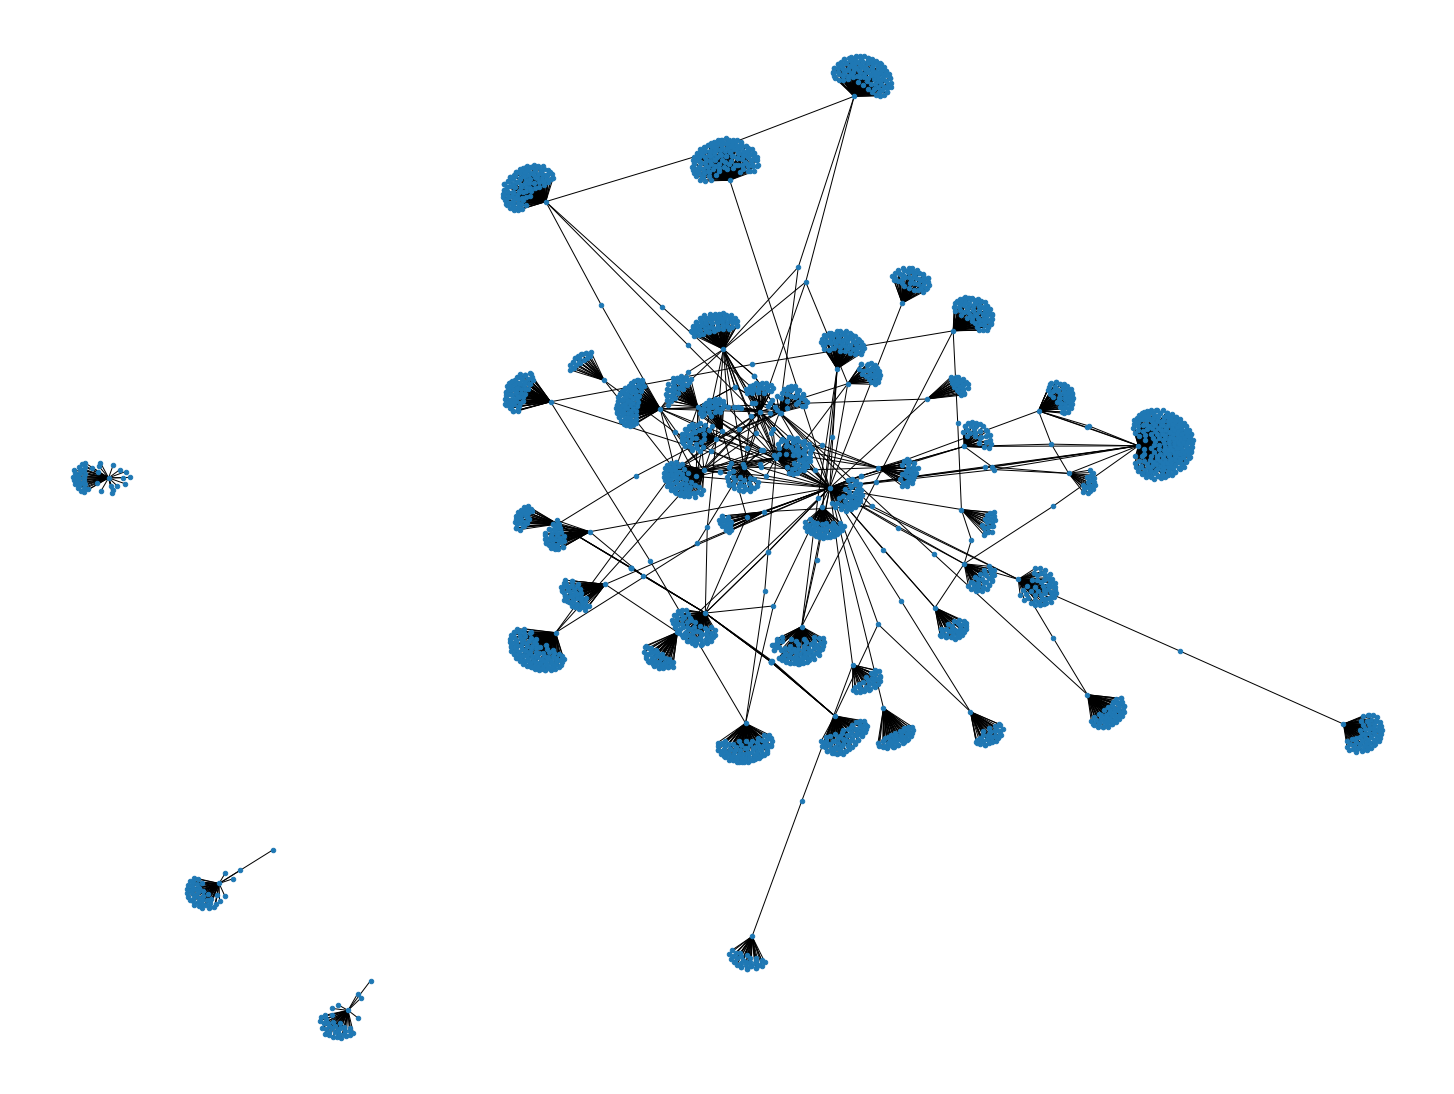

In [168]:
plt.figure(figsize = (20,15))
nx.draw(likes_graph, node_size = 20)